# Introducing RetinAnalysis!
2025-07-18 Lab Meeting Demo

## Setup & dependencies
Core dependencies of retinanalysis:
- visionloader
- datajoint + docker database
- env setup documented in .txt file

Path setup in `config.ini`:

>[DEFAULT]<br>
analysis = /Volumes/data-1/analysis<br>
data = /Volumes/data-1/data/sorted<br>
h5 = /Volumes/data-1/data/h5<br>
meta = /Volumes/data-1/datajoint_testbed/mea/meta<br>
tags = /Volumes/data-1/datajoint_testbed/mea/tags<br>
user = vyomr<br>

Do it once and you're good! Can add as many `[name]` configs for different OS etc.

# Design principles
## Part 1: Data container classes
Separating Data containers into Stimulus and Response classes, with subclasses for single cell and MEA:

### Stimulus classes for epoch blocks:
- `StimBlock` 
    - All metadata for this epoch block, with `df_epochs` table of epoch parameters.
    - `regenerate_stimulus` method with expanding list of Protocols for which we have implemented methods.
    - That's all you need for single-cell. For MEA:
        - ->`MEAStimBlock` corresponding to `datafile_name`
        - Finds `nearest_noise_chunk`
- `StimGroup`: collection of `StimBlock`s, still under construction

### Corresponding Response classes:
- `ResponseBlock`
    - Contains stimulus timing, frame_times, and frame monitor data.
    - -> `SCResponseBlock`
        -  Contains amp1 data, runs Max's spike_detector (python port) to get `spike_times`.
    - -> `MEAResponseBlock`
        - Contains vcd, `df_spike_times` table of cells with spike times for each epoch.
        - Can bin spike times by bin_rate or frame times, stored in `binned_spikes`
- `ResponseGroup` under construction.

### Class for noise chunk data:
- `AnalysisChunk`
    - Contains RF params, corrected for any crop, and options for stixels, pixels, um units

## Part 2: Doer Pipeline classes:
- `DedupBlock`:
    - Deduplication analysis. Contains spike amplitudes, EIs, spatial maps. 
    - Methods for identifying merger candidates and plotting EI, spike amplitude diagnostics.
- `MEAPipeline`:
    - Contains `stim_block`, `response_block` and `analysis_chunk`
    - Fast cluster matching based on EI correlation. Options for different methods of EI signal processing, and for using ISI and timecourse correlations.
- `PresentImagesSplitter`:
    - First pass at single cell pipeline for `PresentImages`


# Let's see it in action!

## Step 1: Querying MEA datasets

In [10]:
import retinanalysis as ra
import matplotlib.pyplot as plt
import tqdm
import numpy as np
display(ra.settings.mea_config)

{'data': '/Volumes/Vyom MEA/analysis',
 'analysis': '/Volumes/Vyom MEA/analysis',
 'h5': '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data',
 'meta': '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta',
 'tags': '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags',
 'user': 'vyomr'}

In [2]:
# Run below if need to reload cell type files
# ra.database_pop.reload_celltypefiles()

# Run below if populating database for the first time
# Or need to load in new experiments
# ra.database_utils.populate_database()

Let's first query MEA datasets by protocol name.

In [3]:
df = ra.get_datasets_from_protocol_names('alpha')
df.head()


Found 1 protocols matching "alpha":
['edu.washington.riekelab.rachel.protocols.DovesPerturbationAlpha']

Found 3 experiments, 4 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250514C,data002,0.5,movies_images,edu.washington.riekelab.rachel.protocols.Doves...,1,20250514C/data002,Doves Perturbation No Jitter Implemented,124,69,2241,3252,488
1,20250514C,data014,0.5,doves_perturb,edu.washington.riekelab.rachel.protocols.Doves...,1,20250514C/data014,Doves Perturbation Jitter Implemented,124,69,2253,3264,487
2,20250527C,data006,0.5,doves_perturb,edu.washington.riekelab.rachel.protocols.Doves...,1,20250527C/data006,Doves perturbation,125,69,2261,3273,495
3,20250626H,data004,2.0,doves1,edu.washington.riekelab.rachel.protocols.Doves...,1,20250626H/data004,Doves perturbation 3R*,128,69,2288,3303,511


Finding typing files for unique experiments: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

Found 1 datasets without any typing files:


,exp_name,datafile_name,nearest_noise_chunk,nearest_noise_distance
0,20250626H,data004,chunk2,23.466667


Found 5 datasets with typing files.
Found 3 unique datasets with typing files and > 0  cells of interest.
Error processing 20250514C, ['data014'], chunk3: 


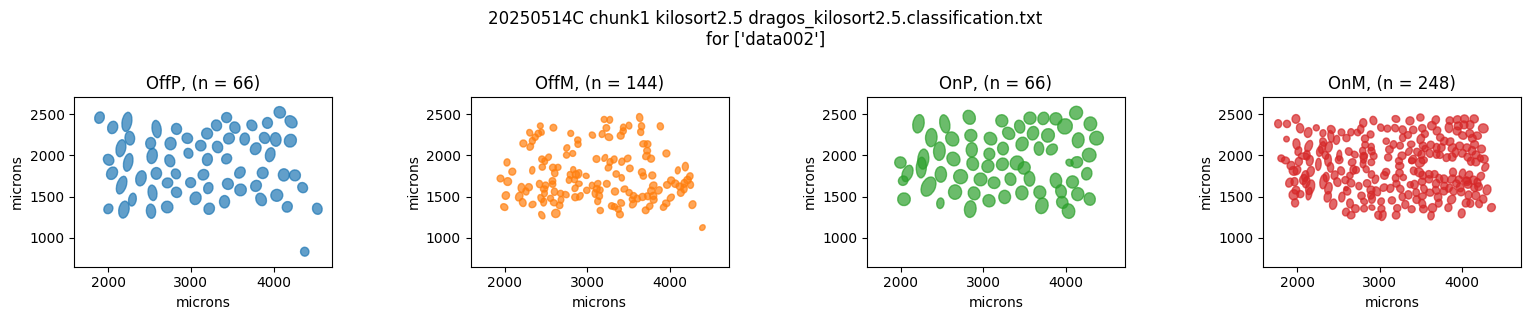

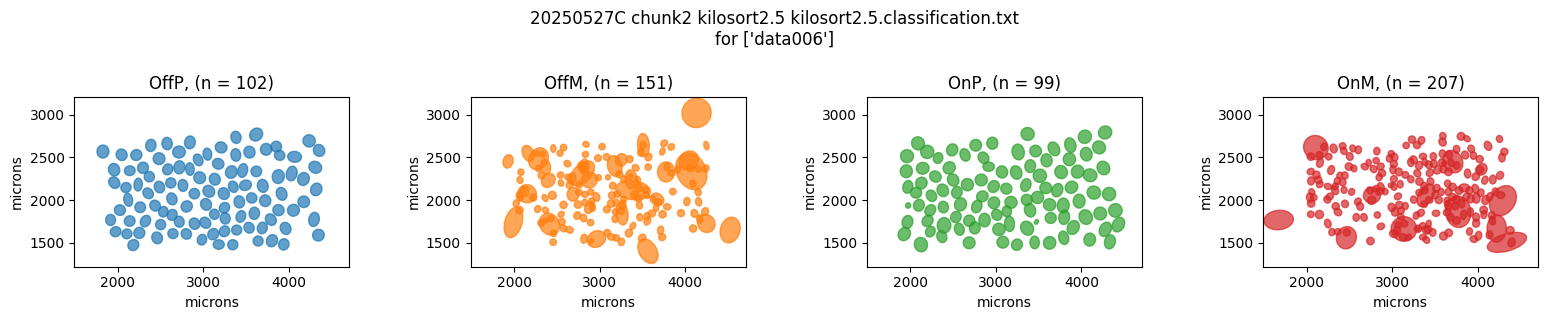

In [4]:
ls_cell_types = ['OffP', 'OffM', 'OnP', 'OnM']

# Plot top 5 datasets according to the highest number of cells
# of interest (sum of # cells of given types)
df_typed, df_not_typed = ra.plot_mosaics_for_all_datasets(df, ls_cell_types, n_top=5)

We can see all the experiments that are totally untyped and need cell typing, as well as mosaics from the experiments with typing files.

## Step 2: Preproc for selected dataset
Deduplication, splitting, etc.

## Step 3: Pipeline for selected dataset

In [5]:
exp_name = '20250527C'
df_summary = ra.get_exp_summary(exp_name)
df_summary.loc[:8]

,exp_name,prep_label,datafile_name,group_label,NDF,chunk_name,protocol_name,duration_minutes,minutes_since_start,start_time,end_time,data_dir,experiment_id,prep_id,group_id,block_id,chunk_id,protocol_id
0,20250527C,Mount1,data000,noise,0.5,chunk1,manookinlab.protocols.SpatialNoise,12.52,12.52,2025-05-27 13:34:45,2025-05-27 13:47:16,20250527C/data000,125,144,2256,3267,496,19
1,20250527C,Mount1,data001,noise,0.5,chunk1,manookinlab.protocols.SpatialNoise,49.43,62.27,2025-05-27 13:47:35,2025-05-27 14:37:01,20250527C/data001,125,144,2256,3268,496,19
2,20250527C,Mount1,data002,CRF,0.5,chunk1,manookinlab.protocols.ContrastResponseGrating,1.23,63.83,2025-05-27 14:37:21,2025-05-27 14:38:35,20250527C/data002,125,144,2257,3269,496,1
3,20250527C,Mount1,data003,moving bars,0.5,motion,manookinlab.protocols.MovingChromaticBar,15.37,79.92,2025-05-27 14:39:18,2025-05-27 14:54:40,20250527C/data003,125,144,2258,3270,498,11
4,20250527C,Mount1,data004,GratingDSOS,0.5,motion,manookinlab.protocols.GratingDSOS,25.18,106.90,2025-05-27 14:56:28,2025-05-27 15:21:39,20250527C/data004,125,144,2259,3271,498,5
5,20250527C,Mount1,data005,Mean Jump Noise,0.5,jump_noise1,edu.washington.riekelab.rachel.protocols.Check...,21.78,133.43,2025-05-27 15:26:24,2025-05-27 15:48:11,20250527C/data005,125,144,2260,3272,493,64
6,20250527C,Mount1,data006,Doves perturbation,0.5,doves_perturb,edu.washington.riekelab.rachel.protocols.Doves...,20.07,159.15,2025-05-27 15:53:50,2025-05-27 16:13:54,20250527C/data006,125,144,2261,3273,495,69
7,20250527C,Mount1,data007,noise,0.5,chunk2,manookinlab.protocols.SpatialNoise,33.98,198.03,2025-05-27 16:18:48,2025-05-27 16:52:47,20250527C/data007,125,144,2262,3274,499,19
8,20250527C,Mount1,data008,noise,0.5,chunk2,manookinlab.protocols.SpatialNoise,30.97,230.57,2025-05-27 16:54:21,2025-05-27 17:25:19,20250527C/data008,125,144,2262,3275,499,19


In [6]:
datafile_name = 'data006'
noise_chunk_name = 'chunk2'
pl = ra.create_mea_pipeline(exp_name, datafile_name, noise_chunk_name)

Initializing StimBlock for 20250527C block 3273
Nearest noise chunk for data006 is chunk2 with distance 5 minutes.

Initializing ResponseBlock for 20250527C block 3273
Loading frame monitor data from /Volumes/data-1/data/h5/20250527C.h5 ...
Loaded (150, 7000) frame_data.
Loading VCD from /Volumes/Vyom MEA/analysis/20250527C/data006/kilosort2.5 ...
VCD loaded with 647 cells.
Loading VCD from /Volumes/Vyom MEA/analysis/20250527C/chunk2/kilosort2.5 ...
VCD loaded with 664 cells.
Loaded spatial maps for channels [0, 2] and 664 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Ref clusters matched: 464
Ref clusters unmatched: 200
69.88% matched, 30.12% unmatched.


['kilosort2.5.classification.txt',
 'dragos_kilosort2.5.classification.txt',
 'autoClassification.txt']

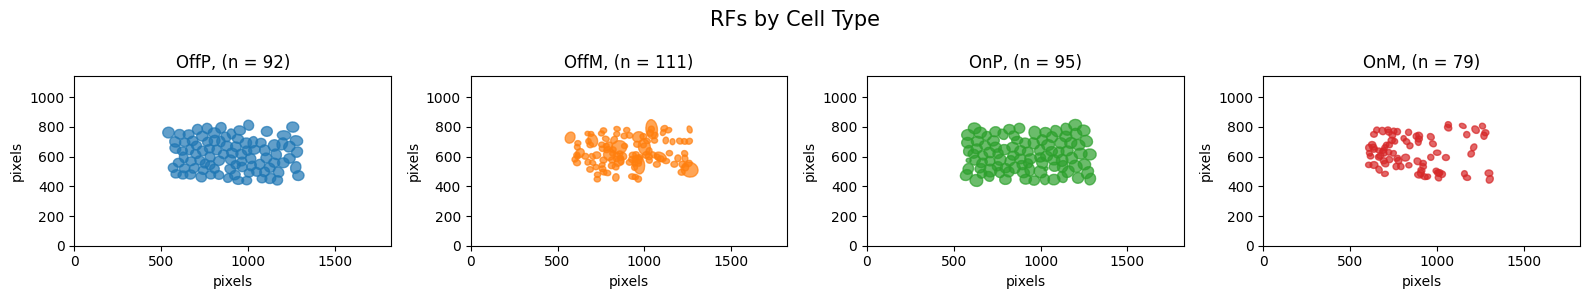

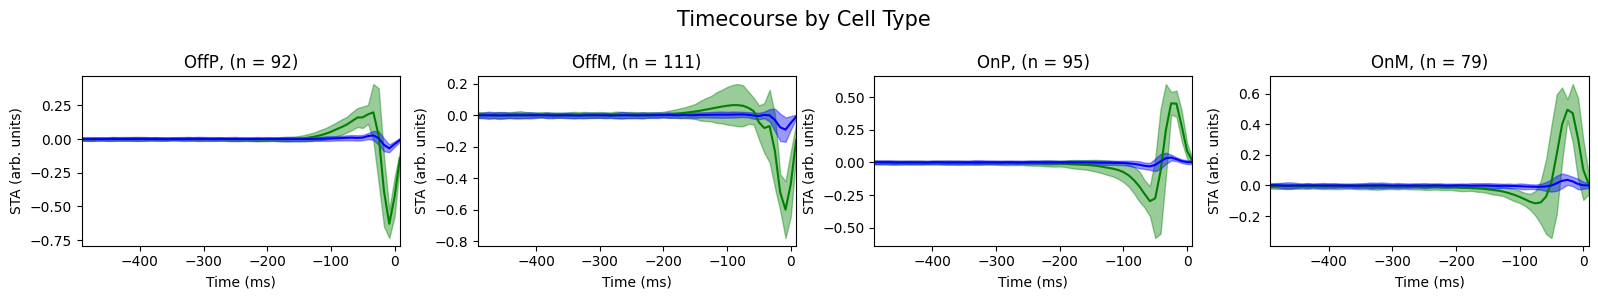

In [7]:
display(pl.analysis_chunk.typing_files)

typing_file_idx = 1
cell_types = ['OffP', 'OffM', 'OnP', 'OnM']
typing_file = pl.analysis_chunk.typing_files[typing_file_idx]
pl.plot_rfs(cell_types=cell_types, typing_file=typing_file)
pl.plot_timecourses(cell_types=cell_types, typing_file=typing_file);
pl.add_types_to_protocol(typing_file)

## Step 4: Protocol specific analysis

#### Regenerating stimulus frames

In [8]:
str_pkg_dir = '/Users/riekelabbackup/Desktop/Vyom/stim_packages/rachel-package/'
pl.stim_block.regenerate_stimulus(str_pkg_dir=str_pkg_dir)

Regenerating stimulus for epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149] in block: 3273
Using regeneration function: make_doves_perturbation_alpha
Starting matlab engine for stim regen.
Started engine and added pkg to path.
Matlab engine stopped.
Stixel size: 60.0 um, grid size: 30.0 um, steps per stixel: 2, stixel shift: 9 pix
Upsampling noise lines to (206, 420)
Stixel size: 60.0 um, grid size

#### Binning spike times by frame times

In [9]:
pl.response_block.bin_spike_times_by_frames()

Binning spikes for cells: 100%|██████████| 647/647 [00:12<00:00, 51.81it/s]


Mean frame rate: 59.94 Hz


#### Protocol specific STA analysis

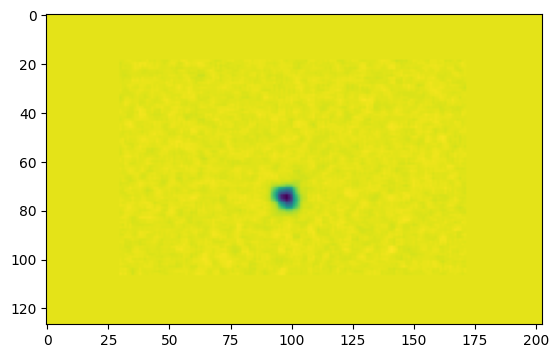

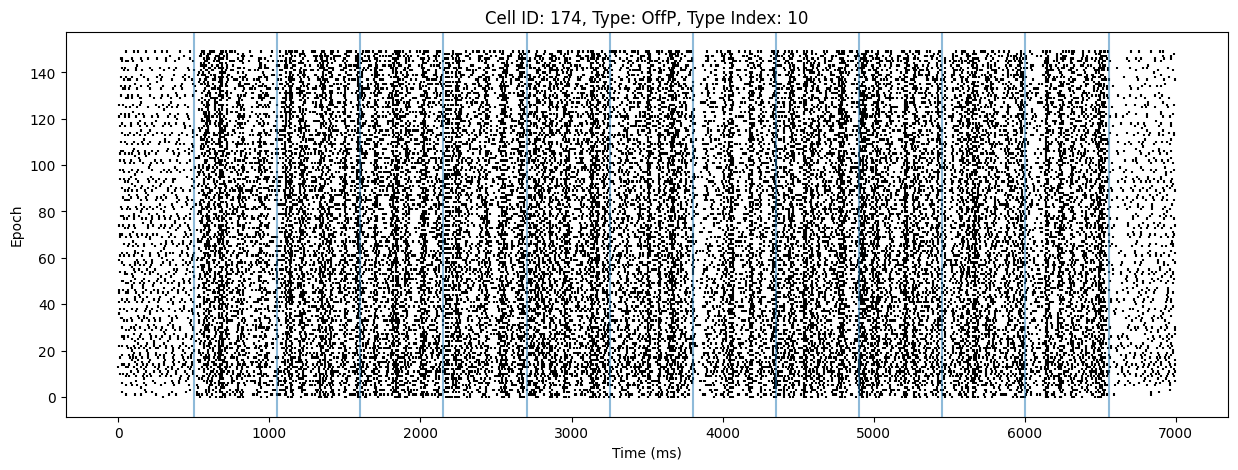

In [100]:
# str_type = 'OnP'
# type_idx = 10
df_st = pl.response_block.df_spike_times
# type_ids = df_st.query('cell_type==@str_type')['cell_id'].values
# cell_id = type_ids[type_idx]
# cell_id = pl.match_dict[802]
cell_id = 174
str_type = df_st.query('cell_id==@cell_id')['cell_type'].values[0]

# Find stim transition frames
arr_fix_indices = pl.stim_block.stim_data['all_fix_indices'][0]
arr_transition_frames = np.where(np.diff(arr_fix_indices))[0] + 1
# Prepend pre_frames
pre_frames = pl.stim_block.stim_data['d_stim_timing']['pre_frames']
arr_transition_frames = np.insert(arr_transition_frames, 0, pre_frames)
frame_rate = 59.941548817817917
arr_transition_times = arr_transition_frames / frame_rate * 1e3
# plt.plot(arr_fix_indices, c='k')
# for tf in arr_transition_frames:
#     plt.axvline(tf)




sts = df_st.query('cell_id==@cell_id')['spike_times'].values[0]
noise_id = pl.get_noise_ids(protocol_ids=[cell_id])[0]
sm = pl.analysis_chunk.d_spatial_maps[noise_id][:,:,0]

plt.figure()
plt.imshow(sm)

f, ax = plt.subplots(figsize=(15,5))
ax.eventplot(sts, color='k')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Epoch')
ax.set_title(f'Cell ID: {cell_id}, Type: {str_type}, Type Index: {type_idx}')
for tt in arr_transition_times:
    ax.axvline(tt, alpha=0.5)

noise_lines = pl.stim_block.stim_data['noise_lines']
# display(noise_lines.shape)
# plt.figure(figsize=(15,5))
# plt.imshow(noise_lines[0])
# plt.colorbar()

cell_idx = np.where(df_st['cell_id'].values==cell_id)[0][0]
cell_fr = pl.response_block.binned_spikes[cell_idx]

def compute_sta(i_section, arr_transition_frames, noise_lines, cell_fr, n_depth = 10):
    onset = arr_transition_frames[i_section]
    offset = arr_transition_frames[i_section+1]
    # onset = arr_transition_frames[0]
    # offset = arr_transition_frames[-1]
    n_epochs = noise_lines.shape[0]

    # Normalize noise_lines to (-1-1)
    # noise_lines = 2 * (noise_lines - np.min(noise_lines)) / (np.max(noise_lines) - np.min(noise_lines)) - 1

    lags = np.arange(0, n_depth)
    sta = np.zeros((len(lags), noise_lines.shape[1]))

    for e_idx in tqdm.trange(n_epochs, desc="Epoch: "):
        frames = noise_lines[e_idx, :, onset:offset].T
        bs = cell_fr[e_idx, onset:offset]
        for i, lag in enumerate(lags):
            resp_shifted = bs#[lag:]
            stim_shifted = frames#[:-lag]
            if lag > 0:
                resp_shifted = bs[lag:]
                stim_shifted = frames[:-lag]
            # Keep only timepoints with a spike
            # mask = np.where(resp_shifted > 0)[0]
            # resp_shifted = resp_shifted[mask]
            # stim_shifted = stim_shifted[mask]
            stim_shifted = np.moveaxis(stim_shifted, 0, -1)
            # print(stim_shifted.shape, resp_shifted.shape)
            sta[i] += np.matmul(stim_shifted, resp_shifted)
    # Normalize the STA to (0-1)
    sta = (sta - np.min(sta)) / (np.max(sta) - np.min(sta))
    # Log scale
    # sta = np.log(sta+1e-6)
    # Subtract mean along columns
    # sta = sta.T
    # sta = sta - sta[-1,:]

    return sta

Epoch: 100%|██████████| 150/150 [00:00<00:00, 1455.29it/s]


Text(0.5, 1.0, 'Argmin at ')

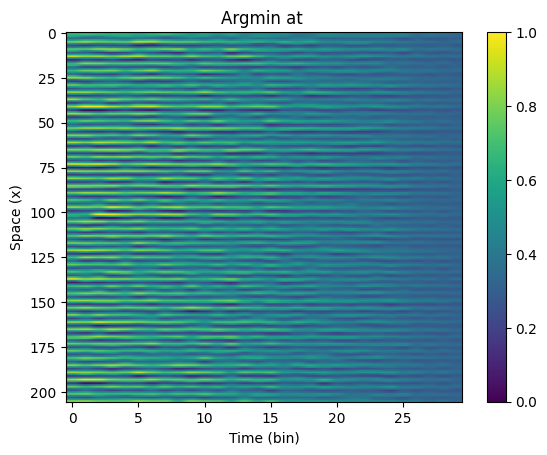

In [101]:
sta = compute_sta(5, arr_transition_frames, noise_lines, cell_fr, n_depth=30)
plt.imshow(sta.T, aspect='auto')
# plt.imshow(np.log(sta.T+1e-3), aspect='auto')
plt.colorbar()
plt.ylabel('Space (x)')
plt.xlabel('Time (bin)')
# Approximate center of cell
s_idx = np.unravel_index(np.argmin(sta), sta.shape)[1]
plt.title(f'Argmin at ')

Epoch: 100%|██████████| 150/150 [00:00<00:00, 4052.21it/s]


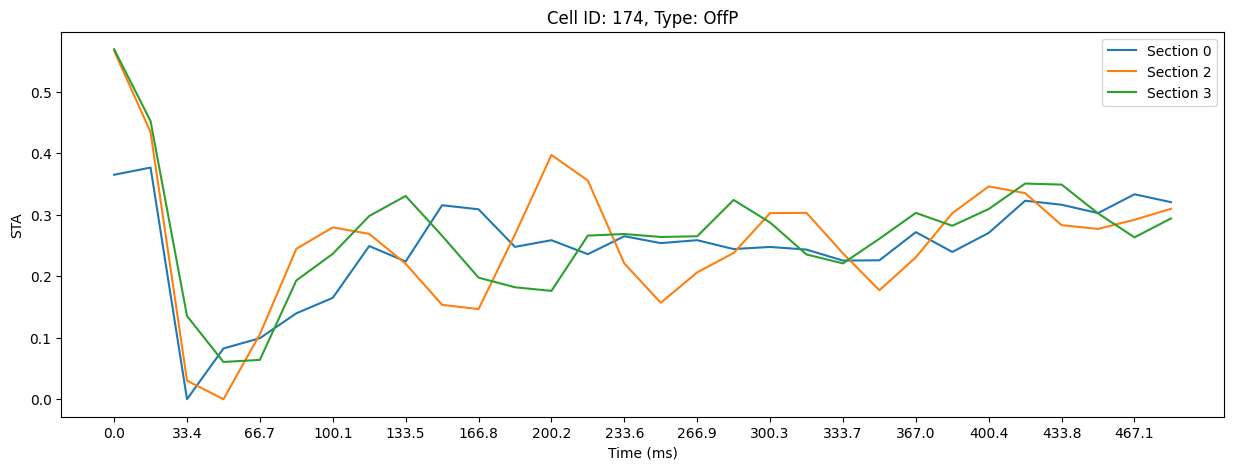

In [103]:
f, ax = plt.subplots(figsize=(15,5))

ls_sections = [0,2,3]#[0, 3, 4, 5]#np.arange(0,10)#
for i_section in ls_sections:
    sta = compute_sta(i_section, arr_transition_frames, noise_lines, cell_fr, n_depth=30)
    ax.plot(sta[:, s_idx], label=f'Section {i_section}')
# Label xtick bins in ms
n_x_spacing = 2
ax.set_xticks(np.arange(0, sta.shape[0], n_x_spacing))
x_labels = np.arange(0, sta.shape[0], n_x_spacing) * (1000 / frame_rate)
# Round to 1 decimal place
x_labels = np.round(x_labels, 1)
ax.set_xticklabels(x_labels)
ax.set_title(f'Cell ID: {cell_id}, Type: {str_type}')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('STA')
ax.legend()